<a href="https://colab.research.google.com/github/wikipathways/BioThings_Explorer_PFOCR_clustering/blob/main/bte_clustering_AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

Installation of required packages. 

In [309]:
!pip install numpy pandas requests requests_cache SetSimilaritySearch fisher > pip-log.txt

In [310]:
from IPython.display import display, HTML
display(HTML('''
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle code view"></form>
'''))
#load packages
from urllib.request import urlopen
import requests
import json
import numpy as np
from copy import copy,deepcopy
import pandas as pd
from fisher import pvalue_npy
from scipy.stats import fisher_exact
# Importing reduce for rolling computations
from functools import reduce
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

## User Inputs

Please complete the form below.

In [438]:
# TRAPI Result URL
trapi_results_url = widgets.Text(
    value='https://arax.ncats.io/api/arax/v1.3/response/7b14f961-9066-41f7-9e3b-d76b2b4a7fac',
    placeholder='Paste here',
    description='',
    disabled=False
)

# Max number of pathway results desired
num_pathways = widgets.IntSlider(
    value=15,
    min=1,
    max=15,
    step=1,
    description='',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Whether to require figure results include user-specified node IDs from the query
# If true then atleast one of the specified query node ids must be in the result figures
# If false then figures without any of these node ids are also included
require_specified_query_nodes = widgets.Checkbox(
    value=True,
    description='',
    disabled=False,
    indent=False
)
require_specified_query_nodes

box_items = [widgets.VBox([widgets.HBox([widgets.Label('TRAPI Result URL:'),trapi_results_url]),
                        widgets.HBox([widgets.Label('Maxiumum number of desired pathway results:'),num_pathways]),
                        widgets.HBox([widgets.Label('Require specified query nodes in pathway results:'),require_specified_query_nodes])])]
widgets.Box(box_items, layout=widgets.Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='62%'
))

Box(children=(VBox(children=(HBox(children=(Label(value='TRAPI Result URL:'), Text(value='https://arax.ncats.i…

## Load TRAPI Results

Retrieve the JSON response from the provided URL.

In [446]:
with urlopen(trapi_results_url.value) as url:
    trapi_results_json = json.load(url)

# get the TRAPI results and knowledge graph from the json response
trapi_message = trapi_results_json['message']
trapi_query = trapi_message["query_graph"]
trapi_results = trapi_message["results"]
trapi_results_df = pd.json_normalize(trapi_results)

# prepare results as a human-readable dataframe
for c in list(trapi_results_df.columns):
    if isinstance(trapi_results_df[c][0], list):
        trapi_results_df[c] = trapi_results_df[c].str[0].str['id']
        
display(trapi_results_df)

normalized_score reasoner_id      score  \
0           100.000000         BTE  12.185940   
1            99.965059         BTE  10.565239   
2            99.930119         BTE   8.948994   
3            99.895178         BTE   8.403776   
4            99.860238         BTE   8.401063   
...                ...         ...        ...   
2857         11.250874         BTE   0.000000   
2858         11.250874         BTE   0.000000   
2859         11.250874         BTE   0.000000   
2860         11.250874         BTE   0.000000   
2861         11.250874         BTE   0.000000   

                      edge_bindings.e0                  edge_bindings.e1  \
0     9dc120bb402235c17afb3b2e3b78fb76  19c2bb57c287f1846c34571c90aaa96e   
1     9dc120bb402235c17afb3b2e3b78fb76  a729758322e7ed6b1e662320f159930c   
2     9dc120bb402235c17afb3b2e3b78fb76  0ab283b0c145cede3da65288cf41f5e3   
3     9dc120bb402235c17afb3b2e3b78fb76  6d800d9b9d88a16396935fff0c448957   
4     9dc120bb402235c17afb3b2e3b78fb76  bb7f943831ff7ba5ea8ce5cdf2e345bd   
...                                ...                               ...   
2857  47b528f4619fe13a988467e04b78b536  0658b9b1928e12f17428a071176f16d7   
2858  47b528f4619fe13a988467e04b78b536  437afad8e33630da291d38455fd1589f   
2859  47b528f4619fe13a988467e04b78b536  e8cd85fe231999bcd49900555ea92437   
2860  47b528f4619fe13a988467e04b78b536  7104e379f43471703d14c8f2a4242ef1   
2861  47b528f4619fe13a988467e04b78b536  eaee4a08d31f8f1d315740d443c09103   

                      edge_bindings.e2         node_bindings.n0  \
0     c7a31c81a608b37d4b3c780a120bbe45  PUBCHEM.COMPOUND:123596   
1     97c08a16970fcd05971ada2697b7e4c6  PUBCHEM.COMPOUND:123596   
2     607b4519f71bb810f7251c14a3f9b2c2  PUBCHEM.COMPOUND:123596   
3     facdce5b3a16f7648de732e39fbfbf5f  PUBCHEM.COMPOUND:123596   
4     120e4972df69ae731d6312f2b4e2b795  PUBCHEM.COMPOUND:123596   
...                                ...                      ...   
2857  0dd0a3b71439e29b7c95313738f0f6d6  PUBCHEM.COMPOUND:123596   
2858  921dce4fb67dfc8fdbc79a31b54f0777  PUBCHEM.COMPOUND:123596   
2859  822825216658be309d0a2c682ca61ddb  PUBCHEM.COMPOUND:123596   
2860  94416892a9fd677acf3c9d3c64b529e7  PUBCHEM.COMPOUND:123596   
2861  fb2a1f106b33c90868ea75eff147aa21  PUBCHEM.COMPOUND:123596   

     node_bindings.n1  node_bindings.n2 node_bindings.n3  
0         NCBIGene:25      NCBIGene:613       HP:0002099  
1         NCBIGene:25      NCBIGene:154       HP:0002099  
2         NCBIGene:25     NCBIGene:7124       HP:0002099  
3         NCBIGene:25     NCBIGene:6776       HP:0002099  
4         NCBIGene:25  UniProtKB:P01585       HP:0002099  
...               ...               ...              ...  
2857    NCBIGene:3725     NCBIGene:5270       HP:0002099  
2858    NCBIGene:3725     NCBIGene:4171       HP:0002099  
2859    NCBIGene:3725    NCBIGene:23038       HP:0002099  
2860    NCBIGene:3725     NCBIGene:5971       HP:0002099  
2861    NCBIGene:3725     NCBIGene:3981       HP:0002099  

[2862 rows x 10 columns]

## Normalize TRAPI Result Dataframe for Enrichment Analysis
  
Unify node identifiers to sources supported by PFOCR pathway figures (NCBIGene, MESH) and prepare CURIE sets for enrichment analysis.

In [501]:
# Using the xrefs in knowledge_graph node attributes we are building dictionaries of 
# result CURIEs and names.
preferred_prefixes = set(["NCBIGene", "MESH"])
curie_to_name = dict()
curie_to_unified_curies = dict()
for k, v in trapi_message["knowledge_graph"]["nodes"].items():
    curie_to_name[k] = v["name"]
    #first check is k is already what we want
    [prefix, identifier] = k.split(":")
    if prefix in preferred_prefixes:
        curie_to_unified_curies[k] = k
    #else dig into attributes to collect one or more relevant mappings
    else:            
        for a in v["attributes"]:
            if a["attribute_type_id"] == "biolink:xref":
                curies = a["value"]
                unified_curies = set()
                for curie in curies:
                    [prefix, identifier] = curie.split(":")
                    if prefix in preferred_prefixes:
                        unified_curies.add(curie)
                #assess collected curies
                if len(unified_curies) == 1:
                    curie_to_unified_curies[k] = list(unified_curies)[0]
                elif len(unified_curies) > 1:
                    curie_to_unified_curies[k] = unified_curies
                    
# Append new columns to results df: name and unified_curie
columns_to_lookup = [col for col in trapi_results_df.columns if col.startswith("node_bindings") and col[-2].lower() == 'n'  and col[-1].isdigit()]
new_name_columns = [col.replace("bindings","name") for col in columns_to_lookup]
new_unified_curies_columns = [col.replace("bindings","unified_curies") for col in columns_to_lookup]

# Simple lookup function
def lookup(row, col, lookup_dict):
    return lookup_dict.get(row[col], 'NA')

# Add the new columns per node by applying the lookup function
for i in range(len(columns_to_lookup)):
    trapi_results_df[new_name_columns[i]] = trapi_results_df.apply(lambda row: lookup(row, columns_to_lookup[i], curie_to_name), axis=1)
    trapi_results_df[new_unified_curies_columns[i]] = trapi_results_df.apply(lambda row: lookup(row, columns_to_lookup[i], curie_to_unified_curies), axis=1)

# Append a new columns: result_name and unified_curie_set for pathway analysis
#trapi_results_df['result_name'] = trapi_results_df[new_name_columns[0]].str.cat(trapi_results_df[new_name_columns], sep="_")
trapi_results_df['result_name'] = trapi_results_df.reset_index().index.astype(str)
trapi_results_df['result_name'] = trapi_results_df['result_name'].str.cat(trapi_results_df[new_name_columns], sep='_')


def collect_curie_set(row):
    unified_curie_set = set()
    for c in new_unified_curies_columns:
        if isinstance(row[c], set):
            unified_curie_set.update(row[c])
        else:
            unified_curie_set.add(row[c])
    return unified_curie_set
trapi_results_df['unified_curie_set'] = trapi_results_df.apply(collect_curie_set, axis=1)
display(trapi_results_df)

normalized_score reasoner_id      score  \
0           100.000000         BTE  12.185940   
1            99.965059         BTE  10.565239   
2            99.930119         BTE   8.948994   
3            99.895178         BTE   8.403776   
4            99.860238         BTE   8.401063   
...                ...         ...        ...   
2857         11.250874         BTE   0.000000   
2858         11.250874         BTE   0.000000   
2859         11.250874         BTE   0.000000   
2860         11.250874         BTE   0.000000   
2861         11.250874         BTE   0.000000   

                      edge_bindings.e0                  edge_bindings.e1  \
0     9dc120bb402235c17afb3b2e3b78fb76  19c2bb57c287f1846c34571c90aaa96e   
1     9dc120bb402235c17afb3b2e3b78fb76  a729758322e7ed6b1e662320f159930c   
2     9dc120bb402235c17afb3b2e3b78fb76  0ab283b0c145cede3da65288cf41f5e3   
3     9dc120bb402235c17afb3b2e3b78fb76  6d800d9b9d88a16396935fff0c448957   
4     9dc120bb402235c17afb3b2e3b78fb76  bb7f943831ff7ba5ea8ce5cdf2e345bd   
...                                ...                               ...   
2857  47b528f4619fe13a988467e04b78b536  0658b9b1928e12f17428a071176f16d7   
2858  47b528f4619fe13a988467e04b78b536  437afad8e33630da291d38455fd1589f   
2859  47b528f4619fe13a988467e04b78b536  e8cd85fe231999bcd49900555ea92437   
2860  47b528f4619fe13a988467e04b78b536  7104e379f43471703d14c8f2a4242ef1   
2861  47b528f4619fe13a988467e04b78b536  eaee4a08d31f8f1d315740d443c09103   

                      edge_bindings.e2         node_bindings.n0  \
0     c7a31c81a608b37d4b3c780a120bbe45  PUBCHEM.COMPOUND:123596   
1     97c08a16970fcd05971ada2697b7e4c6  PUBCHEM.COMPOUND:123596   
2     607b4519f71bb810f7251c14a3f9b2c2  PUBCHEM.COMPOUND:123596   
3     facdce5b3a16f7648de732e39fbfbf5f  PUBCHEM.COMPOUND:123596   
4     120e4972df69ae731d6312f2b4e2b795  PUBCHEM.COMPOUND:123596   
...                                ...                      ...   
2857  0dd0a3b71439e29b7c95313738f0f6d6  PUBCHEM.COMPOUND:123596   
2858  921dce4fb67dfc8fdbc79a31b54f0777  PUBCHEM.COMPOUND:123596   
2859  822825216658be309d0a2c682ca61ddb  PUBCHEM.COMPOUND:123596   
2860  94416892a9fd677acf3c9d3c64b529e7  PUBCHEM.COMPOUND:123596   
2861  fb2a1f106b33c90868ea75eff147aa21  PUBCHEM.COMPOUND:123596   

     node_bindings.n1  node_bindings.n2 node_bindings.n3       node_name.n0  \
0         NCBIGene:25      NCBIGene:613       HP:0002099  Imatinib mesylate   
1         NCBIGene:25      NCBIGene:154       HP:0002099  Imatinib mesylate   
2         NCBIGene:25     NCBIGene:7124       HP:0002099  Imatinib mesylate   
3         NCBIGene:25     NCBIGene:6776       HP:0002099  Imatinib mesylate   
4         NCBIGene:25  UniProtKB:P01585       HP:0002099  Imatinib mesylate   
...               ...               ...              ...                ...   
2857    NCBIGene:3725     NCBIGene:5270       HP:0002099  Imatinib mesylate   
2858    NCBIGene:3725     NCBIGene:4171       HP:0002099  Imatinib mesylate   
2859    NCBIGene:3725    NCBIGene:23038       HP:0002099  Imatinib mesylate   
2860    NCBIGene:3725     NCBIGene:5971       HP:0002099  Imatinib mesylate   
2861    NCBIGene:3725     NCBIGene:3981       HP:0002099  Imatinib mesylate   

     node_unified_curies.n0 node_name.n1 node_unified_curies.n1  \
0           MESH:D000068877         ABL1            NCBIGene:25   
1           MESH:D000068877         ABL1            NCBIGene:25   
2           MESH:D000068877         ABL1            NCBIGene:25   
3           MESH:D000068877         ABL1            NCBIGene:25   
4           MESH:D000068877         ABL1            NCBIGene:25   
...                     ...          ...                    ...   
2857        MESH:D000068877          JUN          NCBIGene:3725   
2858        MESH:D000068877          JUN          NCBIGene:3725   
2859        MESH:D000068877          JUN          NCBIGene:3725   
2860        MESH:D000068877          JUN          NCBIGene:3725   
2861        M

## Collect CURIEs specified in query

Prepare a set of unified CURIEs from the specified query nodes. This set will be used to restrict or prioritize enrichment results based on the user parameter: `require_specified_query_nodes`.

In [462]:
#get all nodes with ids from the query 
user_specified_ids = set()
for k, v in trapi_query['nodes'].items():
    node_ids = v.get('ids', [])
    if node_ids:
        n = trapi_results[0]['node_bindings'][k][0]['id']
        c = curie_to_unified_curies.get(n)
        if isinstance(c, set):
            user_specified_ids.update(c)
        else:
            user_specified_ids.add(c)
print(user_specified_ids)        

{'MESH:D001249', 'MESH:D016535', 'MESH:D000068877'}


## Load PFOCR Pathway Figure Database

Load pathway figure content and metadata for enrichment analysis.

In [539]:
# read in figure metadata for all PFOCR figures
figure_metadata_df = pd.read_csv('https://www.dropbox.com/s/9jorbzpq2k8n5tr/figures_metadata.csv?dl=1', index_col=0)

# read in figure CURIES for all PFOCR figures
figure_curie_df = pd.read_csv('https://www.dropbox.com/s/y3ks74obs3nrjjz/figures_curie.csv?dl=1')

# Define total sets of unified curies for enrichment test
total_pfocr_pathways = len(figure_metadata_df.index)
print("Total number of PFOCR pathways: ", total_pfocr_pathways)
total_pfocr_curies = set(figure_curie_df['curie'])
print("Total number of PFOCR pathway curies: ", len(total_pfocr_curies))
total_result_curies = set([item for sub_set in trapi_results_df['unified_curie_set'] for item in sub_set])
total_result_curies_possible = total_result_curies.intersection(total_pfocr_curies) #only consider possible matches
print("Total number of TRAPI result curies: ", len(total_result_curies_possible))

Total number of PFOCR pathways:  77719
Total number of PFOCR pathway curies:  30163
Total number of TRAPI result curies:  571


## Iterative Enrichment of TRAPI Results Using PFOCR Pathway Figures

We identify the top PFOCR figures by iteratively running Fisher's Exact Test to identify PFOCR figures that are most similar to all the CURIEs from the BTE TRAPI results. To get each figure, we do the following:

1. Run Fisher's Exact Test for the CURIEs from each figure vs. the set of the unique CURIEs found from all the TRAPI results, limiting each set of CURIEs to those found in any PFOCR pathway figure
2. Select the figure with the lowest p-value as a cluster figure
3. Exclude that figure and the CURIEs in it
4. Repeat to get the next cluster figure, continuing until:
    - we run out of enrichement results
    - we repeated steps 1-3 the desired number of times (user input: ```num_pathways```)

In [540]:
# Definition the parameters with example values for enrichment test
# M = 30163  # Total number of curies in PFOCR pathway figure database
# N = 571   # Total number of curies in TRAPI result set
# x = 10   # Number of curies in the TRAPI result set that belong to a particular pathway
# k = 24   # Number of curies in a particular pathway 

def set_union(series):
    return reduce(lambda x, y: x | y, series)

def create_set(series):
    return set(series.tolist())

def get_results_by_curies(curie_set):
    subset_df = trapi_results_df[trapi_results_df['unified_curie_set'].apply(lambda x: len(x.intersection(curie_set)) > 0)]
    return set(subset_df['result_name'].tolist())

pathway_figure_data = []
def get_next_pathway_figures(
    possible_matched_pfocr_curie_count,
    remaining_figures_df,
    remaining_trapi_curie_count,
    required_curies,
    iteration_limit=num_pathways.value, #this is the user-defined parameter for the number of figures
    i=0,
    pathway_figure_ids=[],
):
    remaining_figure_count = len(
        remaining_figures_df
    )

    if (
        i >= iteration_limit
    ) or (
        len(remaining_trapi_curie_count) == 0
    ) or (
        remaining_figure_count == 0
    ):
        return pathway_figure_ids
    
    remaining_figures_df["figure_curie_count"] = remaining_figures_df["curie_set"].map(len)

    remaining_figures_df["figure_curies_in_trapi_results"] = remaining_figures_df["curie_set"].map(
        lambda curie_set: remaining_trapi_curie_count.intersection(
            set(curie_set)
        )
    )

    # number of CURIEs in both TRAPI results and figure = x
    remaining_figures_df["yes_trapi_results_yes_figure"] = remaining_figures_df[
        "figure_curies_in_trapi_results"
    ].map(len)

    # number of CURIEs in TRAPI results but not in figure = N-x
    remaining_figures_df["yes_trapi_results_no_figure"] = (
        len(remaining_trapi_curie_count) -
        remaining_figures_df["yes_trapi_results_yes_figure"]
    )

    # number of CURIEs not in TRAPI results but in figure = k-x
    remaining_figures_df["no_trapi_results_yes_figure"] = (
        remaining_figures_df["figure_curie_count"] -
        remaining_figures_df["yes_trapi_results_yes_figure"]
    )

    # number of CURIEs not in TRAPI results and not in figure = M-k-(N-x)
    # ie., number of unique CURIEs only in other figures
    remaining_figures_df["no_trapi_results_no_figure"] = (
        possible_matched_pfocr_curie_count -
        remaining_figures_df["figure_curie_count"] -
        remaining_figures_df["yes_trapi_results_no_figure"]
    )

    # Vectorized fisher_exact test, see https://stackoverflow.com/a/58661068/5354298
    # Contingency table values (in arg order): x, N-x, k-x, M-k-(N-x) 
    _, _, twosided = pvalue_npy(
        remaining_figures_df["yes_trapi_results_yes_figure"].to_numpy('uint'),
        remaining_figures_df["yes_trapi_results_no_figure"].to_numpy('uint'),
        remaining_figures_df["no_trapi_results_yes_figure"].to_numpy('uint'),
        remaining_figures_df["no_trapi_results_no_figure"].to_numpy('uint'),
    )

    remaining_figures_df["p_value"] = pd.Series(twosided, index=remaining_figures_df.index)
    remaining_figures_df["p_value"].sort_values()
    
    # In case of a p_value tie, we sort by yes_trapi_results_yes_figure count and keep the top single hit
    min_df = remaining_figures_df[
        remaining_figures_df["p_value"] == remaining_figures_df["p_value"].min()
    ]
    min_df = min_df.sort_values(by='yes_trapi_results_yes_figure', ascending=False).head(1)
    
    if required_curies:
        # TODO: it might make sense to keep prioritizing the required CURIEs, but
        #       it's not clear whether this is always what we want.
        #       In some cases, we could obscure a different set of results that may
        #       be valuable but not because of the overlap with the required CURIEs.
        curies_to_exclude = set(
            min_df["figure_curies_in_trapi_results"].agg(set_union)
        ) - required_curies
    else:
        curies_to_exclude = set(min_df["figure_curies_in_trapi_results"].agg(set_union))
        
    if len(curies_to_exclude - required_curies) == 0:
        # On this iteration, we failed to match any new CURIE(s), other than
        # possibly just the required CURIEs.
        return pathway_figure_ids
        
    new_pathway_figure_ids = min_df.index.tolist()
    pathway_figure_ids.extend(new_pathway_figure_ids)
    
    for pathway_figure_id, min_row in min_df.iterrows():
        pathway_figure_data.append({
            "iteration": i,
            "figure_id": pathway_figure_id,
            "p_value": min_row["p_value"],
            "yes_trapi_results_yes_figure": min_row["yes_trapi_results_yes_figure"],
            "yes_trapi_results_no_figure": min_row["yes_trapi_results_no_figure"],
            "no_trapi_results_yes_figure": min_row["no_trapi_results_yes_figure"],
            "no_trapi_results_no_figure": min_row["no_trapi_results_no_figure"],
            "figure_curies_in_trapi_results": min_row["figure_curies_in_trapi_results"],
            "trapi_result_set": get_results_by_curies(curies_to_exclude),
            "trapi_result_count": 0,
            "curie_set": min_row["curie_set"],
            "curies_to_exclude": curies_to_exclude,
            "len_curies_to_exclude": len(curies_to_exclude),
            "remaining_figure_count": remaining_figure_count,
            "remaining_trapi_curie_count": len(remaining_trapi_curie_count),
            "pathway_figure_id_count": len(pathway_figure_ids),
        })
    
    # for next iteration, exclude figures we've already added to cluster figures
    next_remaining_figures_df = remaining_figures_df[
        (~remaining_figures_df.index.isin(
            pathway_figure_ids
        ))
    ]
    
    print(
        f'iteration {i:>2}: figures: {len(new_pathway_figure_ids):>2}, CURIEs: {len(curies_to_exclude):>2}'
    )
    
    return get_next_pathway_figures(
        possible_matched_pfocr_curie_count,
        next_remaining_figures_df.reset_index().set_index("figure_id"),
        remaining_trapi_curie_count - curies_to_exclude,
        required_curies,
        iteration_limit,
        i + 1,
        pathway_figure_ids,
    )

possible_matched_figure_curie_df = figure_curie_df[figure_curie_df["curie"].isin(
    list(total_pfocr_curies)
)]
possible_matched_pfocr_curie_count = len(set(
    possible_matched_figure_curie_df["curie"].drop_duplicates()
))
print(f'possible_matched_pfocr_curie_count: {possible_matched_pfocr_curie_count}')

possible_matched_figures_df = possible_matched_figure_curie_df[
    ["figure_id", "curie"]
].groupby("figure_id").agg(
    create_set
).rename(columns={
    "curie": "curie_set"
})

possible_matched_figures_df["figure_curies_in_trapi_results_count"] = possible_matched_figures_df[
    "curie_set"
].map(
    lambda curie_set: len(total_result_curies_possible.intersection(
        set(curie_set)
    ))
)

overlapping_possible_matched_figures_df = possible_matched_figures_df[
    possible_matched_figures_df["figure_curies_in_trapi_results_count"] > 0
]

# Require that figures have user-specified CURIEs from the query
if require_specified_query_nodes.value:
    required_curies = user_specified_ids
if required_curies:
    overlapping_possible_matched_figures_df = overlapping_possible_matched_figures_df[
        overlapping_possible_matched_figures_df["curie_set"].map(
            # require all of them
            # lambda curie_set: len(curie_set.intersection(required_curies)) == len(required_curies)
            # require at least one of them
            lambda curie_set: len(curie_set.intersection(required_curies)) > 0
        )
    ]

pathway_figure_ids_out = get_next_pathway_figures(
    possible_matched_pfocr_curie_count,
    overlapping_possible_matched_figures_df.reset_index().set_index("figure_id"),
    total_result_curies_possible,
    required_curies,
)
print(f'pathway figure count: {len(pathway_figure_ids_out)}')
pathway_figure_df = pd.DataFrame.from_records(pathway_figure_data)
pathway_figure_df['trapi_result_count'] = pathway_figure_df['trapi_result_set'].apply(lambda x: len(x))
display(pathway_figure_df)

possible_matched_pfocr_curie_count: 30163
iteration  0: figures:  1, CURIEs:  8
iteration  1: figures:  1, CURIEs:  9
iteration  2: figures:  1, CURIEs: 23
iteration  3: figures:  1, CURIEs: 25
iteration  4: figures:  1, CURIEs: 21
iteration  5: figures:  1, CURIEs:  7
iteration  6: figures:  1, CURIEs: 52
iteration  7: figures:  1, CURIEs: 17
iteration  8: figures:  1, CURIEs:  4
pathway figure count: 9


iteration                                 figure_id       p_value  \
0          0       PMC7023894__nihms-1556086-f0004.jpg  6.872071e-08   
1          1             PMC3606047__nihms438583f1.jpg  7.047661e-08   
2          2  PMC8065335__41392_2021_568_Fig5_HTML.jpg  1.141221e-07   
3          3        PMC4100143__ijms-15-10116-g001.jpg  2.156874e-07   
4          4        PMC5866851__MI2018-3858032.002.jpg  1.494529e-07   
5          5                   PMC6399501__475fig1.jpg  1.081569e-07   
6          6                  PMC6556902__bby025f2.jpg  1.542536e-07   
7          7      PMC4973429__fphar-07-00237-g0002.jpg  7.676606e-08   
8          8          PMC4346735__zh00051576930001.jpg  4.447451e-06   

   yes_trapi_results_yes_figure  yes_trapi_results_no_figure  \
0                             9                          562   
1                            10                          553   
2                            24                          530   
3                            26                          505   
4                            22                          484   
5                             8                          477   
6                            53                          425   
7                            18                          408   
8                             5                          404   

   no_trapi_results_yes_figure  no_trapi_results_no_figure  \
0                            4                       29588   
1                           11                       29589   
2                            9                       29600   
3                           11                       29621   
4                           15                       29642   
5                           29                       29649   
6                           17                       29668   
7                           22                       29715   
8                           14                       29740   

                      figure_curies_in_trapi_results  \
0  {MESH:D001249, NCBIGene:59, NCBIGene:4659, NCB...   
1  {MESH:D001249, NCBIGene:134, NCBIGene:135, NCB...   
2  {MESH:D001249, NCBIGene:6372, NCBIGene:6374, N...   
3  {NCBIGene:3605, MESH:D001249, NCBIGene:3586, N...   
4  {MESH:D001249, NCBIGene:5600, NCBIGene:6352, N...   
5  {NCBIGene:7357, MESH:D001249, NCBIGene:55331, ...   
6  {MESH:D001249, NCBIGene:55620, NCBIGene:5728, ...   
7  {NCBIGene:2354, MESH:D001249, NCBIGene:23236, ...   
8  {MESH:D001249, NCBIGene:7048, NCBIGene:925, NC...   

                                    trapi_result_set  trapi_result_count  \
0  {2033_Imatinib mesylate_AKT1_RHOA_Asthma, 2596...                  34   
1  {1235_Imatinib mesylate_CXCL8_AHR_Asthma, 768_...                  25   
2  {2270_Imatinib mesylate_CXCL8_IGF2_Asthma, 233...                 569   
3  {1312_Imatinib mesylate_CASP7_TGFB3_Asthma, 45...                 149   
4  {2120_Imatinib mesylate_CDK6_MAPK14_Asthma, 24...                 144   
5  {2631_Imatinib mesylate_PDGFRA_MBTPS1_Asthma, ...                  25   
6  {2041_Imatinib mesylate_JUN_BLM_Asthma, 2795_I...                 206   
7  {1807_Imatinib mesylate_JUN_HAVCR2_Asthma, 145...                 320   
8  {695_Imatinib mesylate_JUN_CD8A_Asthma, 505_Im...                  11   

                                           curie_set  \
0  {MESH:D001249, NCBIGene:59, NCBIGene:4659, NCB...   
1  {MESH:D001249, MESH:D058186, MESH:D008103, MES...   
2  {MESH:D001249, MESH:D009336, NCBIGene:6372, NC...   
3  {NCBIGene:3605, MESH:D001249, NCBIGene:6773, N...   
4  {MESH:D001249, NCBIGene:5600, NCBIGene:27111, ...   
5  {NCBIGene:7357, MESH:D001249, NCBIGene:2583, M...   
6  {MESH:D001249, NCBIGene:57172, NCBIGene:55620,...   
7  {MESH:D005947, MESH:D001249, NCBIGene:5332, NC...   
8  {MESH:D001249, NCBIGene:7124, NCBIGene:6955, N...   

                                   curies_to_exclude  len_curies_to_exclude  \
0  {NCBIGene:59, NCBIGene:4659, NCBIGene:71, NCBI...      

# Overview of Results

The figures and tables below summarize the intersections and groupings of your TRAPI results with published pathway figures from the PFOCR daatbase.

### TRAPI results grouped by pathway figures

TODO: Render each figure in iteration order with a table of the results containing intersecting CURIEs (not including the "required" CURIEs) such that users can browse groups of results that have representative figures.

### Matrix of TRAPI results by pathway figures

TODO: build a binary heatmap: rows are concatenated result nodes (from results df in notebook), sorted by original result number (e.g., 0-7), and columns are figures, sorted by iteration order. Need to exclude the query-specified nodes from the overlap logic.

In [561]:
#as heatmap, sorting rows by pathway figure groupings
pathway_figure_df_tall = pathway_figure_df[["figure_id","trapi_result_set"]].explode("trapi_result_set")
rep_trapi_result_count = len(pathway_figure_df_tall['trapi_result_set'].unique())
pathway_figure_df_tall = pathway_figure_df_tall.rename(columns={"trapi_result_set": "TRAPI results"})
pathway_figure_df_tall
pathway_figure_df_tall["value"]=1
df=pd.pivot_table(pathway_figure_df_tall, values="value", index=["TRAPI results"], columns="figure_id", fill_value=0)
df=df[pathway_figure_df['figure_id']]
df=df.sort_values(by=list(df.columns))
#display(df)
print('Total number of TRAPI results represented by pathways:', rep_trapi_result_count, 'out of', len(trapi_results_df.index))

Total number of TRAPI results represented by pathways: 1309 out of 2862


Figures by TRAPI results, sorting rows by pathway figure groupings


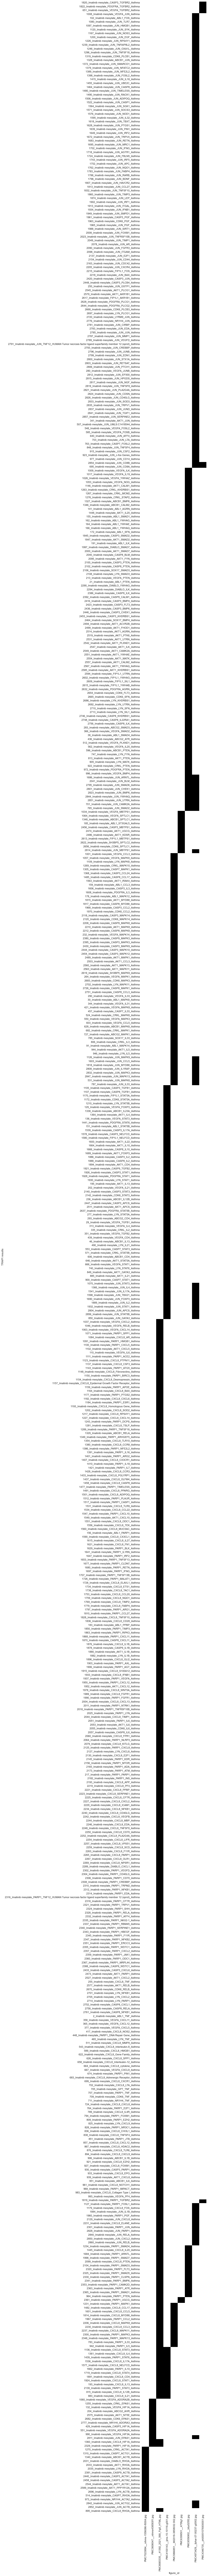

In [562]:
plt.figure(figsize = (5,200))
sns.set()
sns.heatmap(df, cmap=plt.get_cmap('binary'), cbar=False) # yticklabels=True
print('Figures by TRAPI results, sorting rows by pathway figure groupings')
plt.show()

Figures by TRAPI results, sorting rows by result score


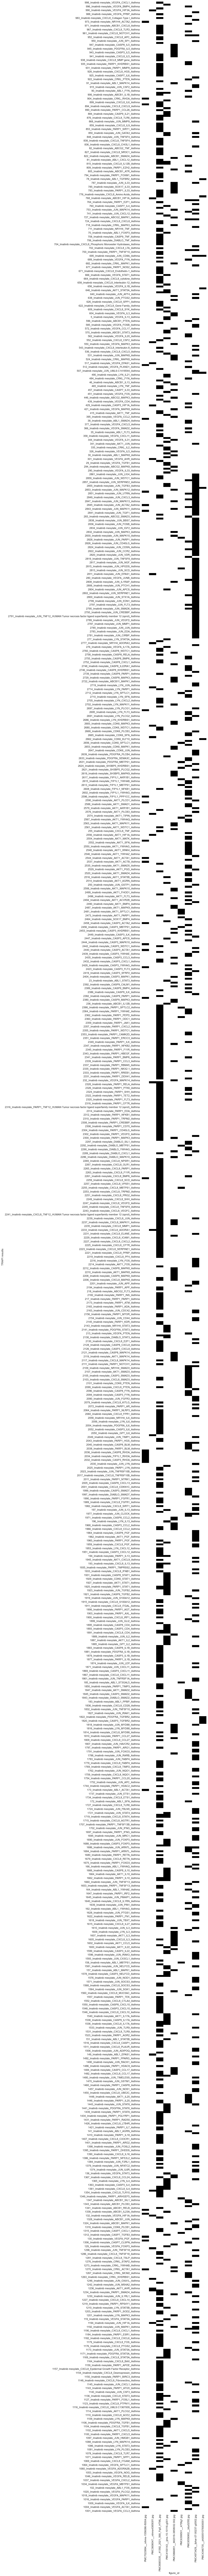

In [558]:
#as heatmap, sorting rows by original TRAPI result score
df=df.sort_values(by='TRAPI results', ascending=False)
plt.figure(figsize = (5,200))
sns.set()
sns.heatmap(df, cmap=plt.get_cmap('binary'), cbar=False) # yticklabels=True
print('Figures by TRAPI results, sorting rows by result score')
plt.show()

### Matrix of result CURIEs by pathway figures

A binary heatmap of CURIES grouped by pathway figures, sorted by significance (i.e., iteration order).

In [563]:
pathway_figure_df_tall_2 = pathway_figure_df[["figure_id","figure_curies_in_trapi_results"]].explode("figure_curies_in_trapi_results")
rep_trapi_result_count = len(pathway_figure_df_tall_2['figure_curies_in_trapi_results'].unique())
pathway_figure_df_tall_2 = pathway_figure_df_tall_2.rename(columns={"figure_curies_in_trapi_results": "curies"})
pathway_figure_df_tall_2
pathway_figure_df_tall_2["value"]=1
df2=pd.pivot_table(pathway_figure_df_tall_2, values="value", index=["curies"], columns="figure_id", fill_value=0)
df2=df2[pathway_figure_df['figure_id']]
df2=df2.sort_values(by=list(df.columns))
#display(df2)
print('Total number of CURIEs represented by pathways:', rep_trapi_result_count, 'out of', len(total_result_curies_possible ))

Total number of CURIEs represented by pathways: 167 out of 571


Figures by CURIEs


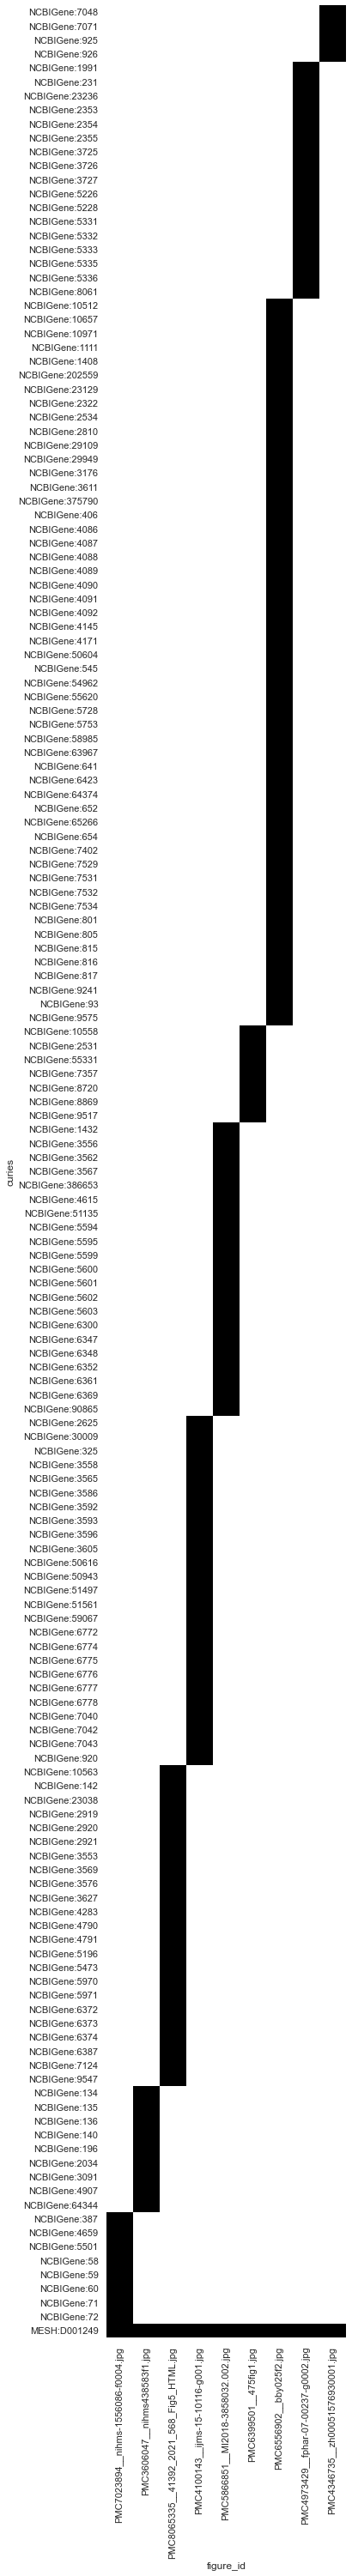

In [557]:
#as heatmap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
plt.figure(figsize = (5,50))
sns.set()
sns.heatmap(df2, cmap=plt.get_cmap('binary'), cbar=False) # yticklabels=True
print('Figures by CURIEs')
plt.show()